# Set-up Environment

In [1]:
spark.version

'3.1.3'

In [2]:
import os
import pandas as pd
import numpy as np

from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
warnings.filterwarnings(action = 'ignore')

In [3]:
!pip3 install nltk -U

In [4]:
import re
import json
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer, IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from google.cloud import storage

spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

## Set-up COS functions for GCP

In [6]:
# List all files in given COS directory
def list_blobs_pd(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix = folder_name))

    blob_name = []
    blob_size = []
    
    for blob in blobs:
        blob_name.append(blob.name)
        blob_size.append(blob.size)

    blobs_df = pd.DataFrame(list(zip(blob_name, blob_size)), columns = ['Name','Size'])

    #blobs_df = blobs_df.style.format({"Size": "{:,.0f}"}) 
    
    return blobs_df

In [7]:
# Delete folder from COS bucket
def delete_folder(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix = folder_name))

    for blob in blobs:
        blob.delete()

In [8]:
# Reading data from bucket
bucket = 'shijia-bdp-class'

# Read Topic Related Data Parquet Files

In [9]:
blob_list = list_blobs_pd(bucket, 'inter_result/related')

In [10]:
blob_list.head(10)

,Name,Size
0,inter_result/related/,0
1,inter_result/related/_SUCCESS,0
2,inter_result/related/part-00000-a01e717a-81ee-4634-bded-d7b1d005e3c3-c000.snappy.parquet,1317439
3,inter_result/related/part-00001-a01e717a-81ee-4634-bded-d7b1d005e3c3-c000.snappy.parquet,1262933
4,inter_result/related/part-00002-a01e717a-81ee-4634-bded-d7b1d005e3c3-c000.snappy.parquet,1627412
5,inter_result/related/part-00003-a01e717a-81ee-4634-bded-d7b1d005e3c3-c000.snappy.parquet,1429290
6,inter_result/related/part-00004-a01e717a-81ee-4634-bded-d7b1d005e3c3-c000.snappy.parquet,1230717
7,inter_result/related/part-00005-a01e717a-81ee-4634-bded-d7b1d005e3c3-c000.snappy.parquet,1420765
8,inter_result/related/part-00006-a01e717a-81ee-4634-bded-d7b1d005e3c3-c000.snappy.parquet,1442606
9,inter_result/related/part-00007-a01e717a-81ee-4634-bded-d7b1d005e3c3-c000.snappy.parquet,1331688


In [11]:
path = 'gs://shijia-bdp-class/inter_result/related'
tweets_topic = spark.read.parquet(path)

In [12]:
tweets_topic.printSchema()

root
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- created_at: string (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- favourites_count: long (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- friends_count: long (nullable = true)
 |    |-- geo_enabled: boolean (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- listed_count: long (nullable = true)
 |    |-- location: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- protected: boolean (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |    |-- statuses_count: long (nullable = true)
 |    |-- verified: boolean (nullable = true)
 |-- quote_c

In [13]:
tweets_topic.count()

1124640

In [14]:
tweets_topic.limit(10).toPandas()

,coordinates,created_at,id,text,user,quote_count,reply_count,favorite_count,retweet_count,retweeted,retweeted_from,retweeted_status,cleaned_text,tokened_text,filtered_tokens,topic
0,None,Thu Sep 15 05:22:58 +0000 2022,1570282000556204033,"RT @cambhomeschool: Does online learning help students secure better jobs in the future? If so, how? Our recent blog covers more insights f…","(Fri Apr 17 11:06:41 +0000 2009, Everest summiteer and writer of the teen/ya series' 'Mortal Chaos' and 'The Everest Files', 7195, 3022, 3747, False, 32367835, 52, Europe and Himalayas, Matt Dickinson, False, Dickinson_Matt, 6247, False)",0,0,0,0,RT,cambhomeschool,"(None, Wed Sep 14 18:53:02 +0000 2022, 1, 1570123473145729024, 0, 0, 1, False, Does online learning help students secure better jobs in the future? If so, how? Our recent blog covers more insigh… https://t.co/QGemcruCoj, (Mon Jul 27 19:51:34 +0000 2015, The UK’s most trusted British online school with 20+ years of experience and MA/MSc/PhD teachers. Delivering online lessons to children aged 7–19 worldwide, 52, 204, 150, False, 3298559047, 10, Cambridge, England, Cambridge Home School Online, False, cambhomeschool, 8819, False))",does online learning help students secure better jobs in the future if so how our recent blog covers more insights f,"[does, online, learning, help, students, secure, better, jobs, in, the, future, if, so, how, our, recent, blog, covers, more, insights, f]","[online, learning, help, students, secure, better, jobs, future, recent, blog, covers, insights, f]",related
1,None,Thu Sep 15 05:23:24 +0000 2022,1570282109948002306,RT @tomzbie: 15 y/o t0mm7 doodling hearts and w¡1bvr's name on all his school books while hes in class cuz hes crushing on his new online b…,"(Sat Aug 06 23:47:32 +0000 2022, 💐💐💐, 187, 10, 71, False, 1556064408220012546, 0, they/she, atlas, False, slutty4atlas, 37, False)",0,0,0,0,RT,tomzbie,"(None, Sat Sep 10 17:35:13 +0000 2022, 232, 1568654341048762374, 1, 1, 32, False, 15 y/o t0mm7 doodling hearts and w¡1bvr's name on all his school books while hes in class cuz hes crushing on his n… https://t.co/p2vbDyyLPx, (Sun Aug 21 01:06:11 +0000 2022, w1lbvr 5o0t cann¡bal truther, 286, 103, 36, False, 1561157639668699138, 0, ⚰️🕊, zom :3 💐, False, tomzbie, 32, False))",15 y o t0mm7 doodling hearts and w 1bvr s name on all his school books while hes in class cuz hes crushing on his new online b,"[15, y, o, t0mm7, doodling, hearts, and, w, 1bvr, s, name, on, all, his, school, books, while, hes, in, class, cuz, hes, crushing, on, his, new, online, b]","[15, y, o, t0mm7, doodling, hearts, w, 1bvr, name, school, books, hes, class, cuz, hes, crushing, new, online, b]",related
2,None,Thu Sep 15 05:24:35 +0000 2022,1570282408716509185,"RT @Kimuzi_: As a grown as person, waiting for your govt to fail is just being timid. It's like putting your child in school and expect him…","(Fri Sep 25 20:43:58 +0000 2020, Mr nice guy®\nYK\n\nStillcookin👨‍🎓\n\n@arsenal ❤️\n\nFree the real \n\nI'm HIM, 506317, 7321, 6785, False, 1309594454664380418, 0, mtaani🇰🇪, vatre❄️, False, IceTrev, 72815, False)",0,0,0,0,RT,Kimuzi_,"(None, Thu Sep 15 03:57:11 +0000 2022, 143, 1570260414146953216, 1, 12, 40, False, As a grown as person, waiting for your govt to fail is just being timid. It's like putting your child in school and… https://t.co/78n7WuLTlR, (Thu Dec 06 11:36:38 +0000 2012, I'm on a new path. Reality is often disappointing., 107256, 63643, 3812, True, 992886834, 59, Nairobi, Kenya, Kimuzi, False, Kimuzi_, 276231, False))",as a grown as person waiting for your govt to fail is just being timid it s like putting your child in school and expect him,"[as, a, grown, as, person, waiting, for, your, govt, to, fail, is, just, being, timid, it, s, like, putting, your, child, in, school, and, expect, him]","[grown, person, waiting, govt, fail, timid, like, putting, child, school, expect]",related
3,None,Thu Sep 15 05:24:35 +0000 2022,1570282411195518977,"RT @glorioziadaisy: As a graduating 

# Message Uniqueness Analysis

In [15]:
# Classify the Twitterers Organization for all Tweets
government_entities = '|'.join(['government', 'agency', 'mayor', 'democracy', 'state', 'gov', 'federal', 'police', 'president', 
                                'law', 'ministry', 'regime', 'rule', 'republic'])
universities = '|'.join(['university', 'uni', 'universities', 'college', 'professor', 'professors', 'undergraduate', 'faculty', 'graduate', 'admission', 'research'])
schools = '|'.join(['school', 'schools', 'high', 'secondary', 'elementary', 'teacher', 'primary', 'kindergarten'])
nonprofit_organizations = '|'.join(['nonprofit', 'ngo', 'npo', 'non-government', 'volunteer', 'not-for-profit', 'nongovernmental', 'charity'])
news_outlets = '|'.join(['news', 'newspaper', 'journal', 'tv', 'media', 'broadcast', 'website', 'times']) 
social_media_influencers = '|'.join(['influencer', 'vlog', 'ambassador', 'instagram', 'ig', 'blog'])

In [16]:
tweets_grouped = tweets_topic.withColumn('group', when(col('user.description').rlike(government_entities), 'government_entities').\
                                                         when(col('user.description').rlike(universities), 'universities').\
                                                         when(col('user.description').rlike(schools), 'schools').\
                                                         when(col('user.description').rlike(nonprofit_organizations), 'nonprofit_organizations').\
                                                         when(col('user.description').rlike(news_outlets), 'news_outlets').\
                                                         when(col('user.description').rlike(social_media_influencers), 'social_media_influencers').\
                                                         otherwise('other')
                                                                       )
tweets_grouped.limit(10).toPandas()

,coordinates,created_at,id,text,user,quote_count,reply_count,favorite_count,retweet_count,retweeted,retweeted_from,retweeted_status,cleaned_text,tokened_text,filtered_tokens,topic,group
0,None,Thu Sep 15 05:22:58 +0000 2022,1570282000556204033,"RT @cambhomeschool: Does online learning help students secure better jobs in the future? If so, how? Our recent blog covers more insights f…","(Fri Apr 17 11:06:41 +0000 2009, Everest summiteer and writer of the teen/ya series' 'Mortal Chaos' and 'The Everest Files', 7195, 3022, 3747, False, 32367835, 52, Europe and Himalayas, Matt Dickinson, False, Dickinson_Matt, 6247, False)",0,0,0,0,RT,cambhomeschool,"(None, Wed Sep 14 18:53:02 +0000 2022, 1, 1570123473145729024, 0, 0, 1, False, Does online learning help students secure better jobs in the future? If so, how? Our recent blog covers more insigh… https://t.co/QGemcruCoj, (Mon Jul 27 19:51:34 +0000 2015, The UK’s most trusted British online school with 20+ years of experience and MA/MSc/PhD teachers. Delivering online lessons to children aged 7–19 worldwide, 52, 204, 150, False, 3298559047, 10, Cambridge, England, Cambridge Home School Online, False, cambhomeschool, 8819, False))",does online learning help students secure better jobs in the future if so how our recent blog covers more insights f,"[does, online, learning, help, students, secure, better, jobs, in, the, future, if, so, how, our, recent, blog, covers, more, insights, f]","[online, learning, help, students, secure, better, jobs, future, recent, blog, covers, insights, f]",related,other
1,None,Thu Sep 15 05:23:24 +0000 2022,1570282109948002306,RT @tomzbie: 15 y/o t0mm7 doodling hearts and w¡1bvr's name on all his school books while hes in class cuz hes crushing on his new online b…,"(Sat Aug 06 23:47:32 +0000 2022, 💐💐💐, 187, 10, 71, False, 1556064408220012546, 0, they/she, atlas, False, slutty4atlas, 37, False)",0,0,0,0,RT,tomzbie,"(None, Sat Sep 10 17:35:13 +0000 2022, 232, 1568654341048762374, 1, 1, 32, False, 15 y/o t0mm7 doodling hearts and w¡1bvr's name on all his school books while hes in class cuz hes crushing on his n… https://t.co/p2vbDyyLPx, (Sun Aug 21 01:06:11 +0000 2022, w1lbvr 5o0t cann¡bal truther, 286, 103, 36, False, 1561157639668699138, 0, ⚰️🕊, zom :3 💐, False, tomzbie, 32, False))",15 y o t0mm7 doodling hearts and w 1bvr s name on all his school books while hes in class cuz hes crushing on his new online b,"[15, y, o, t0mm7, doodling, hearts, and, w, 1bvr, s, name, on, all, his, school, books, while, hes, in, class, cuz, hes, crushing, on, his, new, online, b]","[15, y, o, t0mm7, doodling, hearts, w, 1bvr, name, school, books, hes, class, cuz, hes, crushing, new, online, b]",related,other
2,None,Thu Sep 15 05:24:35 +0000 2022,1570282408716509185,"RT @Kimuzi_: As a grown as person, waiting for your govt to fail is just being timid. It's like putting your child in school and expect him…","(Fri Sep 25 20:43:58 +0000 2020, Mr nice guy®\nYK\n\nStillcookin👨‍🎓\n\n@arsenal ❤️\n\nFree the real \n\nI'm HIM, 506317, 7321, 6785, False, 1309594454664380418, 0, mtaani🇰🇪, vatre❄️, False, IceTrev, 72815, False)",0,0,0,0,RT,Kimuzi_,"(None, Thu Sep 15 03:57:11 +0000 2022, 143, 1570260414146953216, 1, 12, 40, False, As a grown as person, waiting for your govt to fail is just being timid. It's like putting your child in school and… https://t.co/78n7WuLTlR, (Thu Dec 06 11:36:38 +0000 2012, I'm on a new path. Reality is often disappointing., 107256, 63643, 3812, True, 992886834, 59, Nairobi, Kenya, Kimuzi, False, Kimuzi_, 276231, False))",as a grown as person waiting for your govt to fail is just being timid it s like putting your child in school and expect him,"[as, a, grown, as, person, waiting, for, your, govt, to, fail, is, just, being, timid, it, s, like, putting, your, child, in, school, and, expect, him]","[grown, person, waiting, govt, fail, timid, like, putting, child, school, expect]",related,other
3,None,Thu Sep 15 05:24:35 +0000 2022,1570282411195518977,"RT @gloriozi

In [17]:
tweets_grouped.printSchema()

root
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- created_at: string (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- favourites_count: long (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- friends_count: long (nullable = true)
 |    |-- geo_enabled: boolean (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- listed_count: long (nullable = true)
 |    |-- location: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- protected: boolean (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |    |-- statuses_count: long (nullable = true)
 |    |-- verified: boolean (nullable = true)
 |-- quote_c

In [18]:
tweets_grouped_ip = tweets_grouped.groupby('group').count()
p_tweets_grouped_ip = tweets_grouped_ip.toPandas()
p_tweets_grouped_ip.head(10)

,group,count
0,schools,25290
1,social_media_influencers,95091
2,government_entities,20517
3,universities,45399
4,other,902657
5,news_outlets,31775
6,nonprofit_organizations,3911


Text(0.5, 1.0, 'Total Tweets Volumne Related to In-person Instruction by Types of Organization')

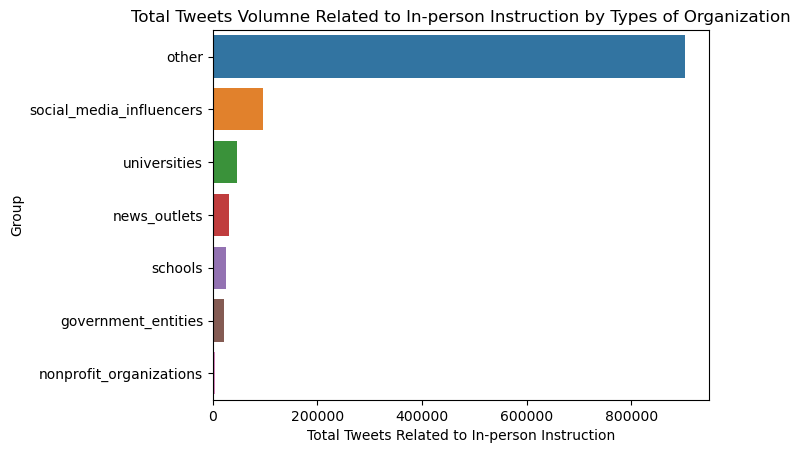

In [19]:
sns.barplot(y = 'group', x = 'count', data = p_tweets_grouped_ip, orient = 'h', 
            order = p_tweets_grouped_ip.sort_values('count',ascending = False).group)
plt.xlabel('Total Tweets Related to In-person Instruction')
plt.ylabel('Group')
plt.title('Total Tweets Volumne Related to In-person Instruction by Types of Organization')

## Step 1. Clean the data, remove stopwords and create index for both tweets text (Already Done)

In [20]:
tweets_text = tweets_grouped.select('id', 'filtered_tokens', 'group').orderBy(rand()).limit(10000) #randomly select 10000 samples
tweets_text.limit(10).toPandas()

,id,filtered_tokens,group
0,1560173462630825984,"[future, doctor, cheating, online, school, rn, better, start, eating, healthy]",other
1,1574415781793767431,"[yeah, psa, people, say, creator, rurouni, kenshin, pedophile, going, terminally, online, school]",other
2,1584422846541213697,"[youtube, powerful, university, planet, use, personal, development, 12, yout]",other
3,1553038584894160896,"[electoral, college, protection, mob, rule, want, feel, person, small, state]",other
4,1526533893062533126,"[school, year, remote, option, covid, 19, looks, like, sad, part, still]",other
5,1515257446721376257,"[cwilbur, type, relative, embarrass, school, grandmother, type, person, get, h]",other
6,1535031433634500614,"[gaussian, process, summer, school, 2022, person, 12, 15, sept, sheffield, registration, open]",other
7,1536522927297814529,"[front, back, konda, team, promoting, konda, film, vikas, engineering, college, vijaywada, personally, like, th]",other
8,1587518813339254784,"[join, us, virtually, saturday, november, 5th, 11am, 1pm, cba, coalition, orientation, learn]",other
9,1580154814402482183,"[liverpool, john, moores, university, student, described, loving, talented, kind, hearted, person, yo]",news_outlets


In [21]:
tweets_text.count()

10000

## Step 2. Fit countvectorizer to create word features

In [22]:
vectorize = CountVectorizer(inputCol = "filtered_tokens", outputCol = "features", minDF = 1.0)

In [23]:
df_vec_text = vectorize.fit(tweets_text).transform(tweets_text)
df_vec_text.limit(5).toPandas()

,id,filtered_tokens,group,features
0,1560173462630825984,"[future, doctor, cheating, online, school, rn, better, start, eating, healthy]",other,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...)"
1,1574415781793767431,"[yeah, psa, people, say, creator, rurouni, kenshin, pedophile, going, terminally, online, school]",other,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,1584422846541213697,"[youtube, powerful, university, planet, use, personal, development, 12, yout]",other,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,1553038584894160896,"[electoral, college, protection, mob, rule, want, feel, person, small, state]",other,"(0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,1526533893062533126,"[school, year, remote, option, covid, 19, looks, like, sad, part, still]",other,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


## Step 3. Fit MinHashLSH to create hash table

In [24]:
mh = MinHashLSH(inputCol = "features", outputCol = "hashes", numHashTables = 5)

In [25]:
model_text = mh.fit(df_vec_text)
df_hashed = mh.fit(df_vec_text).transform(df_vec_text)
df_hashed.limit(5).toPandas()

,id,filtered_tokens,group,features,hashes
0,1560173462630825984,"[future, doctor, cheating, online, school, rn, better, start, eating, healthy]",other,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...)","[[47945584.0], [186285538.0], [30854182.0], [192418556.0], [101788110.0]]"
1,1574415781793767431,"[yeah, psa, people, say, creator, rurouni, kenshin, pedophile, going, terminally, online, school]",other,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[47945584.0], [165221165.0], [30854182.0], [461219945.0], [303608627.0]]"
2,1584422846541213697,"[youtube, powerful, university, planet, use, personal, development, 12, yout]",other,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[107491830.0], [82677203.0], [59525226.0], [183486957.0], [75795118.0]]"
3,1553038584894160896,"[electoral, college, protection, mob, rule, want, feel, person, small, state]",other,"(0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[271988023.0], [101089805.0], [405418686.0], [229017585.0], [23594946.0]]"
4,1526533893062533126,"[school, year, remote, option, covid, 19, looks, like, sad, part, still]",other,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","[[47945584.0], [163426159.0], [195383692.0], [24570879.0], [316712217.0]]"


In [26]:
df_hashed.printSchema()

root
 |-- id: long (nullable = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- group: string (nullable = false)
 |-- features: vector (nullable = true)
 |-- hashes: array (nullable = true)
 |    |-- element: vector (containsNull = true)



## Step 4. Establish similarity threshold and return near-duplicate records

### Low Jaccard Distance

In [27]:
jaccard_distance = 0.3

In [28]:
df_dups_text = model_text.approxSimilarityJoin(df_hashed, df_hashed, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
#            col('datasetA.text').alias('text_A'),
#            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )


In [29]:
df_dups_30_text = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B
0,0.0,1560173462630825984,1560212205005688832
1,0.0,1560173462630825984,1561556126017134592
2,0.0,1560173462630825984,1560487532218818560
3,0.0,1560173462630825984,1560619767933063173
4,0.0,1560173462630825984,1560624532519632897


In [30]:
records = df_dups_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate texts based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique texts based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  51694
Duplicate texts based on { 0.3 } jaccard distance:  3635
Unique texts based on { 0.3 } jaccard distance:  0.3 :  48059


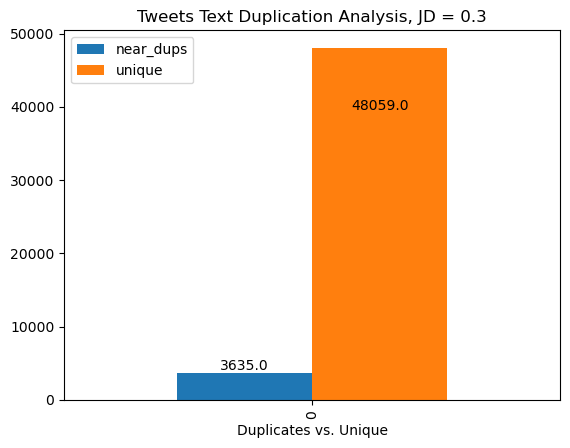

In [31]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax = dups_df.plot(kind = 'bar',y = ['near_dups', 'unique'], fontsize = 10, color = ['C0', 'C1'], align = 'center', width = 0.6, xlabel = "Duplicates vs. Unique")
ax.set_title('Tweets Text Duplication Analysis, JD = 0.3', fontsize = 12)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()*0.8), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### Medium Jaccard Distance

In [32]:
jaccard_distance = 0.5

In [33]:
df_dups_text = model_text.approxSimilarityJoin(df_hashed, df_hashed, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
#            col('datasetA.text').alias('text_A'),
#            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )


In [34]:
df_dups_50_text = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B
0,0.0,1560173462630825984,1560212205005688832
1,0.0,1560173462630825984,1561556126017134592
2,0.0,1560173462630825984,1560487532218818560
3,0.0,1560173462630825984,1560619767933063173
4,0.0,1560173462630825984,1560624532519632897


In [35]:
records = df_dups_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate texts based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique texts based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  55185
Duplicate texts based on { 0.5 } jaccard distance:  3906
Unique texts based on { 0.5 } jaccard distance:  0.5 :  51279


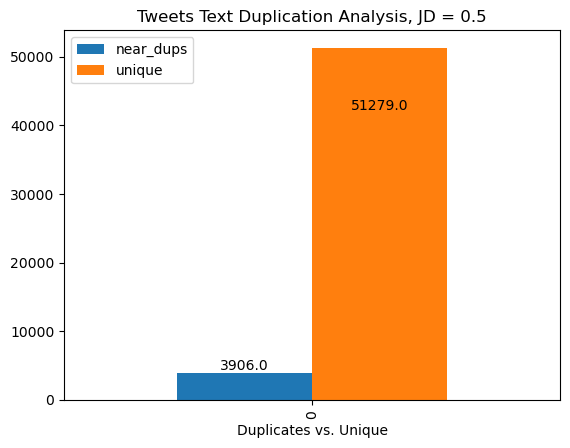

In [36]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax = dups_df.plot(kind = 'bar',y = ['near_dups', 'unique'], fontsize = 10, color = ['C0', 'C1'], align = 'center', width = 0.6, xlabel = "Duplicates vs. Unique")
ax.set_title('Tweets Text Duplication Analysis, JD = 0.5', fontsize = 12)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()*0.8), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### High Jaccard Distance

In [37]:
jaccard_distance = 0.7

In [38]:
df_dups_text = model_text.approxSimilarityJoin(df_hashed, df_hashed, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.filtered_tokens').alias('tokens_A'),
            col('datasetB.filtered_tokens').alias('tokens_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [39]:
df_dups_70_text = df_dups_text
df_dups_text.cache()
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,tokens_A,tokens_B
0,0.0,1560173462630825984,1560212205005688832,"[future, doctor, cheating, online, school, rn, better, start, eating, healthy]","[future, doctor, cheating, online, school, rn, better, start, eating, healthy]"
1,0.0,1560173462630825984,1561556126017134592,"[future, doctor, cheating, online, school, rn, better, start, eating, healthy]","[future, doctor, cheating, online, school, rn, better, start, eating, healthy]"
2,0.0,1560173462630825984,1560487532218818560,"[future, doctor, cheating, online, school, rn, better, start, eating, healthy]","[future, doctor, cheating, online, school, rn, better, start, eating, healthy]"
3,0.0,1560173462630825984,1560619767933063173,"[future, doctor, cheating, online, school, rn, better, start, eating, healthy]","[future, doctor, cheating, online, school, rn, better, start, eating, healthy]"
4,0.0,1560173462630825984,1560624532519632897,"[future, doctor, cheating, online, school, rn, better, start, eating, healthy]","[future, doctor, cheating, online, school, rn, better, start, eating, healthy]"


In [40]:
records = df_dups_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate texts based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique texts based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  86684
Duplicate texts based on { 0.7 } jaccard distance:  4657
Unique texts based on { 0.7 } jaccard distance:  0.7 :  82027


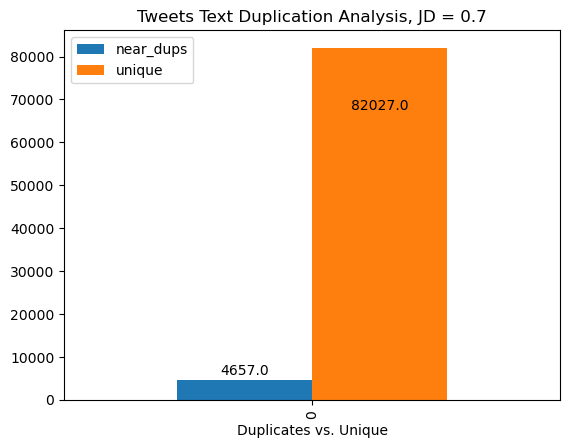

In [41]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax = dups_df.plot(kind = 'bar',y = ['near_dups', 'unique'], fontsize = 10, color = ['C0', 'C1'], align = 'center', width = 0.6, xlabel = "Duplicates vs. Unique")
ax.set_title('Tweets Text Duplication Analysis, JD = 0.7', fontsize = 12)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()*0.8), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

## Step 5. Compare thresholds side-by-side

In [42]:
df_dups_30_id = df_dups_30_text.select(col('id_A').alias('id_30_A'), col('id_B').alias('id_30_B'))
df_dups_50_id = df_dups_50_text.select(col('id_A').alias('id_50_A'), col('id_B').alias('id_50_B'))
df_dups_70_id = df_dups_70_text.select(col('tokens_A'), col('tokens_B'), col('id_A').alias('id_70_A'), col('id_B').alias('id_70_B'))

print(df_dups_30_id.count())
print(df_dups_50_id.count())
print(df_dups_70_id.count())

51694
55185
86684


In [43]:
dups_combined = df_dups_70_id.join(df_dups_50_id, on=((df_dups_70_id.id_70_A == df_dups_50_id.id_50_A) & 
                                                      (df_dups_70_id.id_70_B == df_dups_50_id.id_50_B)), how="left_outer")\
                             .join(df_dups_30_id, on=((df_dups_70_id.id_70_A == df_dups_30_id.id_30_A) 
                                                      & (df_dups_70_id.id_70_B == df_dups_30_id.id_30_B)), how="left_outer")

dups_combined.limit(5)

tokens_A,tokens_B,id_70_A,id_70_B,id_50_A,id_50_B,id_30_A,id_30_B
"[future, doctor, ...","[future, doctor, ...",1560173462630825984,1560212205005688832,1560173462630825984,1560212205005688832,1560173462630825984,1560212205005688832
"[future, doctor, ...","[future, doctor, ...",1560173462630825984,1561556126017134592,1560173462630825984,1561556126017134592,1560173462630825984,1561556126017134592
"[future, doctor, ...","[future, doctor, ...",1560173462630825984,1560487532218818560,1560173462630825984,1560487532218818560,1560173462630825984,1560487532218818560
"[future, doctor, ...","[future, doctor, ...",1560173462630825984,1560619767933063173,1560173462630825984,1560619767933063173,1560173462630825984,1560619767933063173
"[future, doctor, ...","[future, doctor, ...",1560173462630825984,1560624532519632897,1560173462630825984,1560624532519632897,1560173462630825984,1560624532519632897


In [44]:
dups_combined = dups_combined.\
                withColumn("threshold_30",\
                           when(col("id_30_A").isNotNull(), "Duplicate").
                           otherwise("Non-Dup")).\
                withColumn("threshold_50",\
                           when(col("id_50_A").isNotNull(), "Duplicate").
                           otherwise("Non-Dup")).\
                withColumn("threshold_70",\
                           when(col("id_70_A").isNotNull(), "Duplicate").
                           otherwise("Non-Dup")).\
                drop('id_30_A', 'id_30_B', 'id_50_A', 'id_50_B', 'id_70_A', 'id_70_B')

dups_combined.limit(5)

tokens_A,tokens_B,threshold_30,threshold_50,threshold_70
"[future, doctor, ...","[future, doctor, ...",Duplicate,Duplicate,Duplicate
"[future, doctor, ...","[future, doctor, ...",Duplicate,Duplicate,Duplicate
"[future, doctor, ...","[future, doctor, ...",Duplicate,Duplicate,Duplicate
"[future, doctor, ...","[future, doctor, ...",Duplicate,Duplicate,Duplicate
"[future, doctor, ...","[future, doctor, ...",Duplicate,Duplicate,Duplicate


## Message Uniqueness by Types of Organization

In [45]:
jaccard_distance = 0.5

In [46]:
df_dups_text_group = model_text.approxSimilarityJoin(df_hashed, df_hashed, jaccard_distance).filter("datasetA.id < datasetB.id")\
                                                                                            .filter("datasetA.group == datasetB.group").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.group').alias('group'),
#            col('datasetB.group').alias('group_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )


In [47]:
df_dups_30_text_group = df_dups_text_group
df_dups_text_group.cache()
df_dups_text_group.limit(5).toPandas()

,distCol,id_A,id_B,group
0,0.0,1560173462630825984,1560487532218818560,other
1,0.0,1560173462630825984,1560619767933063173,other
2,0.0,1560173462630825984,1560624532519632897,other
3,0.0,1574415781793767431,1574502541009862682,other
4,0.0,1574415781793767431,1574905618925703168,other


In [48]:
records = df_dups_text_group.groupby('group').agg(count("*").alias('Total_Records'))
dups = df_dups_text_group.select('id_A', 'group').distinct().groupby('group').agg(count("*").alias('Duplication'))
uniques = records.join(dups, on = "group", how = 'inner').withColumn('Unique', records.Total_Records - dups.Duplication).orderBy('total_records', ascending = False).toPandas()
uniques

,group,Total_Records,Duplication,Unique
0,other,40406,3211,37195
1,social_media_influencers,414,144,270
2,universities,338,50,288
3,news_outlets,48,30,18
4,schools,21,17,4
5,government_entities,16,13,3
6,nonprofit_organizations,3,2,1


In [49]:
stk_uniques = uniques.set_index('group')
stk_uniques = stk_uniques.stack().to_frame('value').reset_index()
stk_uniques.rename(columns={'level_1':'type'},inplace = True)
stk_uniques

,group,type,value
0,other,Total_Records,40406
1,other,Duplication,3211
2,other,Unique,37195
3,social_media_influencers,Total_Records,414
4,social_media_influencers,Duplication,144
5,social_media_influencers,Unique,270
6,universities,Total_Records,338
7,universities,Duplication,50
8,universities,Unique,288
9,news_outlets,Total_Records,48


Text(0.5, 1.0, 'Tweets Duplication Related to In-person Instruction by Types of Organization, JD = 0.5')

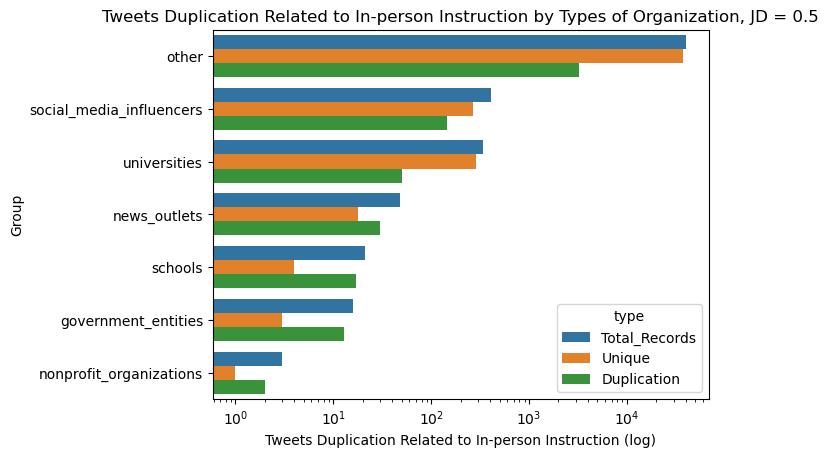

In [50]:
sns.barplot(x = "value", y = "group", hue = "type", data = stk_uniques, hue_order = ['Total_Records', 'Unique', 'Duplication'])
plt.xscale('log')
plt.xlabel('Tweets Duplication Related to In-person Instruction (log)')
plt.ylabel('Group')
plt.title('Tweets Duplication Related to In-person Instruction by Types of Organization, JD = 0.5')